In [1]:
## Start - Parameters and Libraries

import DrainMethod
import sys
import os

## General parameters 

input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
#logName = 'Ciena_error_lines_20220701-20220715.txt' # Name of file to be parsed
#logName = 'ciena-mini.txt' # Name of file to be parsed
logName = 'Andriod_2k.log' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

In [2]:
## First Step - Log Parsing Using Drain

## Drain parameters

st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Code

print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
parser.parse(log_file)

parsedresult=os.path.join(output_dir, log_file + '_structured.csv')   


=== Starting Drain Parsing ===
/home/vbertalan/Downloads/CSL-1/CSL/logs/
Parsing file: /home/vbertalan/Downloads/CSL-1/CSL/logs/Andriod_2k.log


Parsing Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Parsing Progress: 100%|██████████| 2000/2000 [00:00<00:00, 18308.74it/s]


Parsing done. [Time taken: 0:00:00.301747]


In [19]:
## Second Step - Embedding Creation Using Transformers

from sentence_transformers import SentenceTransformer
from pathlib import Path
import pandas as pd
import regex as re
import contextlib
import pickle

## General Parameters

vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
indir = os.path.join(input_dir, os.path.dirname(logName)) # Input directory

## Code

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors.vec')
    path = Path(path_to_file)
    vectors = []

    if (path.is_file()):
        vectors = pickle.load(open(path_to_file, 'rb'))
    else:
        # Using standard MPNet transformer
        model = SentenceTransformer('all-mpnet-base-v2')
        print("Iniciando encode")
        vectors = model.encode(raw_content)
        pickle.dump(vectors, open(path_to_file, 'wb'))
    
    return vectors

# Creates embeddings for log file
def transform(logName):
    print('Transforming file: ' + os.path.join(input_dir, logName))
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

vector_mat = transform(os.path.basename(logName))


Transforming file: /home/vbertalan/Downloads/CSL-1/CSL/logs/Andriod_2k.log


In [20]:
print(type(vector_mat))
print("O número de linhas do arquivo transformado é {}".format(len(vector_mat)))
print("O número de colunas do arquivo transformado é {}".format(len(vector_mat[0])))
print(vector_mat[2][1])
print(vector_mat[0][0])

<class 'numpy.ndarray'>
O número de linhas do arquivo transformado é 2000
O número de colunas do arquivo transformado é 768
-0.04948146
-0.0075010364


In [6]:
## Third Step - Creates matrix of parsed items

from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import pandas as pd 

## General Parameters

output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
#logName = 'Ciena_error_lines_20220701-20220715.txt' # Name of file to be parsed
#logName = 'ciena-mini.txt' # Name of file to be parsed
logName = 'Andriod_2k.log' # Name of file to be parsed
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
var_df = full_df["ParameterList"]

# Breaks the string into lists
for i, line in var_df.items():
    var_df.at[i] = literal_eval(var_df.at[i])

# Transforms variables list to variable matrix
mlb = MultiLabelBinarizer()
var_matrix = pd.DataFrame(mlb.fit_transform(var_df),columns=mlb.classes_)
print (var_matrix.shape)

(2000, 1839)


In [25]:
## Fourth Step - Concatenates Embeddings Matrix with Variables Matrix Using Numpy

import numpy as np

var_mat = var_matrix.to_numpy()

print("A matrix de vetores tem {} linhas".format(len(vector_mat)))
print("A matrix de vetores tem {} colunas".format(len(vector_mat[0])))
print("A matrix de variaveis tem {} linhas".format(len(var_mat)))
print("A matrix de variaveis tem {} colunas".format(len(var_mat[0])))

concat_matrix = np.hstack((vector_mat,var_mat))

print("A matrix concatenada tem {} linhas".format(len(concat_matrix)))
print("A matrix concatenada tem {} colunas".format(len(concat_matrix[0])))

#np.savetxt("concat_matrix_numpy.csv", concat_matrix, delimiter=";")


A matrix de vetores tem 2000 linhas
A matrix de vetores tem 768 colunas
A matrix de variaveis tem 2000 linhas
A matrix de variaveis tem 1839 colunas
A matrix concatenada tem 2000 linhas
A matrix concatenada tem 2607 colunas


In [33]:
## Alternate Fourth Step - Concatenates Embeddings Matrix with Variables Matrix Using Pandas

vector_df = pd.DataFrame(vector_mat, columns = None)

print("A matrix de vetores tem formato {}".format(vector_df.shape))
print("A matrix de variaveis tem formato {}".format(var_matrix.shape))

concat_matrix = pd.concat([vector_df, var_matrix], axis=1)

print("A matrix de variaveis tem formato {}".format(concat_matrix.shape))

#concat_matrix.to_csv("concat_matrix_pandas.csv")

A matrix de vetores tem formato (2000, 768)
A matrix de variaveis tem formato (2000, 1839)
A matrix de variaveis tem formato (2000, 2607)


In [42]:
## Fifth Step - Clustering with HDBScan

import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer = hdbscan.HDBSCAN(min_cluster_size=50,min_samples=1,metric='euclidean',
                            allow_single_cluster=False,cluster_selection_method='leaf')
clusterer.fit(concat_matrix)
cluster_num = clusterer.labels_.max()
print ("O numero de clusters e {}".format(cluster_num))
cluster_labels = clusterer.labels_
print ("Os clusters de cada elemento sao {}".format(cluster_labels))

O numero de clusters e 8
Os clusters de cada elemento sao [ 7  7 -1 ...  8  8  8]



/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


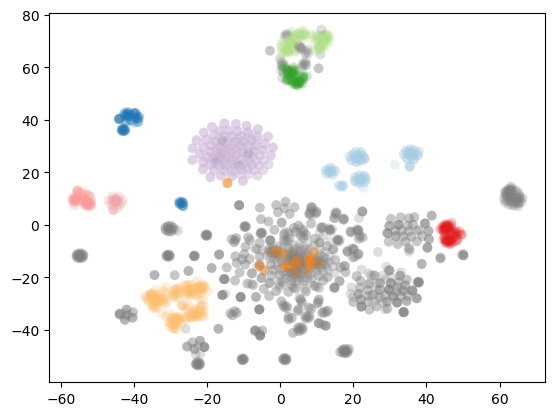

In [43]:
## Sixth Step - Plotting with TSNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

projection = TSNE().fit_transform(concat_matrix)
#plt.scatter(*projection.T, **plot_kwds)

color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)